# BRAIN TUMOR DETECTOR

Dataset obtained from: https://www.kaggle.com/datasets/navoneel/brain-mri-images-for-brain-tumor-detection/data

In [2]:
import os
import shutil
from shutil import copyfile

import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from PIL import Image
import matplotlib.pyplot as plt

In [3]:
SOURCE_DIR = './brain_tumor_dataset/'
ROOT_DIR = './data/'

In [4]:
def create_train_val_dirs(ROOT_DIR):

    if os.path.exists(ROOT_DIR):
        shutil.rmtree(ROOT_DIR)

    os.makedirs(os.path.join(ROOT_DIR, './training/yes'))
    os.makedirs(os.path.join(ROOT_DIR, './training/no'))
    os.makedirs(os.path.join(ROOT_DIR, './validation/yes'))
    os.makedirs(os.path.join(ROOT_DIR, './validation/no'))

create_train_val_dirs(ROOT_DIR)

In [5]:
def print_subdirs(ROOT_DIR):
    for root, dirs, files in os.walk(ROOT_DIR):
        for name in dirs:
            print(os.path.join(root, name))

print_subdirs(ROOT_DIR)

./data/validation
./data/training
./data/validation/no
./data/validation/yes
./data/training/no
./data/training/yes


In [6]:
def split_data(SOURCE_DIR, TRAIN_DIR, VALIDATION_DIR, SPLIT_SIZE):

    all_files = []

    for file in os.listdir(SOURCE_DIR):
        if os.path.getsize(os.path.join(SOURCE_DIR, file)) > 0:
            all_files.append(file)
        else:
            print(file + " is zero length, so ignoring.")
    
    np.random.shuffle(all_files)

    SPLIT_POINT = int(len(all_files) * SPLIT_SIZE)

    train_files = all_files[:SPLIT_POINT]
    validation_files = all_files[SPLIT_POINT:]

    for file in train_files:
        src = os.path.join(SOURCE_DIR, file)
        dest = os.path.join(TRAIN_DIR, file)
        copyfile(src, dest)

    for file in validation_files:
        src = os.path.join(SOURCE_DIR, file)
        dest = os.path.join(VALIDATION_DIR, file)
        copyfile(src, dest)

In [7]:
POSITIVE_SOURCE_DIR = './brain_tumor_dataset/yes'
NEGATIVE_SOURCE_DIR = './brain_tumor_dataset/no'

TRAINING_DIR = './data/training'
VALIDATION_DIR = './data/validation'

POSITIVE_TRAIN_DIR = os.path.join(TRAINING_DIR, 'yes')
NEGATIVE_TRAIN_DIR = os.path.join(TRAINING_DIR, 'no')

POSITIVE_VALIDATION_DIR = os.path.join(VALIDATION_DIR, 'yes')
NEGATIVE_VALIDATION_DIR = os.path.join(VALIDATION_DIR, 'no')

## ***************************************

split_size = .8

split_data(POSITIVE_SOURCE_DIR, POSITIVE_TRAIN_DIR, POSITIVE_VALIDATION_DIR, split_size)
split_data(NEGATIVE_SOURCE_DIR, NEGATIVE_TRAIN_DIR, NEGATIVE_VALIDATION_DIR, split_size)

print(f'Positive Images: {len(os.listdir(POSITIVE_SOURCE_DIR))}')
print(f'Negative Images: {len(os.listdir(NEGATIVE_SOURCE_DIR))}')

print(f'Training Positive Images: {len(os.listdir(POSITIVE_TRAIN_DIR))}')
print(f'Training Negative Images: {len(os.listdir(NEGATIVE_TRAIN_DIR))}')

print(f'Validation Positive Images: {len(os.listdir(POSITIVE_VALIDATION_DIR))}')
print(f'Validation Negative Images: {len(os.listdir(NEGATIVE_VALIDATION_DIR))}')

Positive Images: 155
Negative Images: 98
Training Positive Images: 124
Training Negative Images: 78
Validation Positive Images: 31
Validation Negative Images: 20


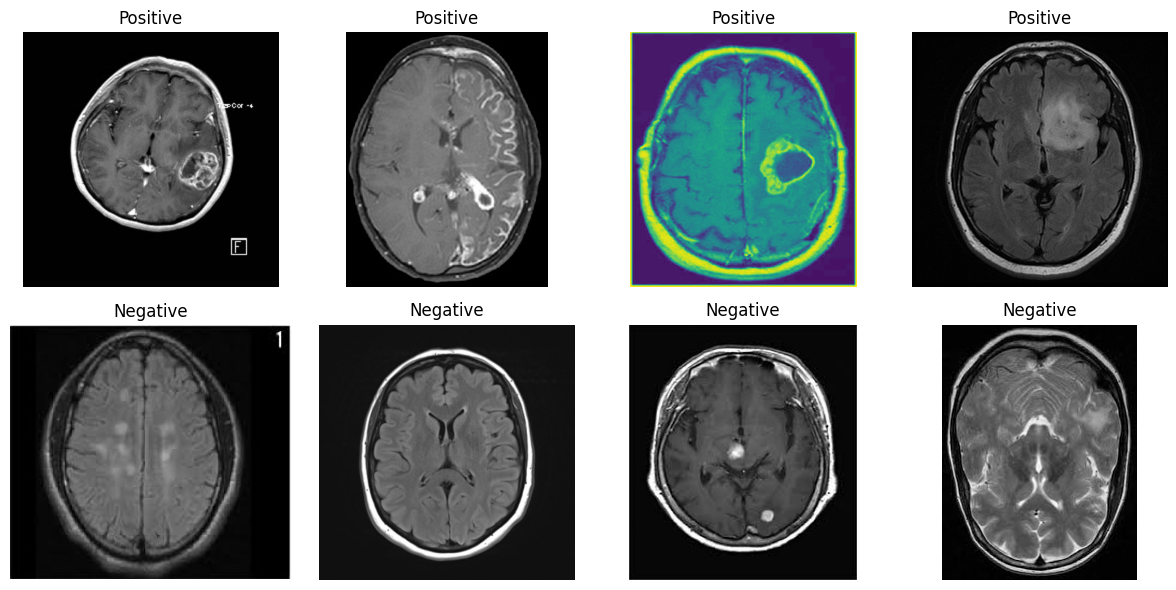

In [8]:
def plot_sample_images(POSITIVE_SOURCE_DIR, NEGATIVE_SOURCE_DIR):
    positive_dir = POSITIVE_SOURCE_DIR
    negative_dir = NEGATIVE_SOURCE_DIR

    positive_files = os.listdir(positive_dir)[:4]
    negative_files = os.listdir(negative_dir)[:4]

    fig, axes = plt.subplots(2, 4, figsize=(12, 6))

    for i, file in enumerate(positive_files):
        img_path = os.path.join(positive_dir, file)
        img = Image.open(img_path)
        axes[0, i].imshow(img)
        axes[0, i].set_title('Positive')
        axes[0, i].axis('off')

    for i, file in enumerate(negative_files):
        img_path = os.path.join(negative_dir, file)
        img = Image.open(img_path)
        axes[1, i].imshow(img)
        axes[1, i].set_title('Negative')
        axes[1, i].axis('off')

    plt.tight_layout()

plot_sample_images(POSITIVE_SOURCE_DIR, NEGATIVE_SOURCE_DIR)

In [9]:
def train_val_gens(TRAINING_DIR, VALIDATION_DIR):

    train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )

    train_generator = train_datagen.flow_from_directory(
        TRAINING_DIR,
        target_size=(150, 150),
        batch_size=10,
        class_mode='binary'
    )

    validation_datagen = ImageDataGenerator(rescale=1./255)

    validation_generator = validation_datagen.flow_from_directory(
        VALIDATION_DIR,
        target_size=(150, 150),
        batch_size=10,
        class_mode='binary'
    )

    return train_generator, validation_generator

In [10]:
train_generator, validation_generator = train_val_gens(TRAINING_DIR, VALIDATION_DIR)

Found 202 images belonging to 2 classes.
Found 51 images belonging to 2 classes.


In [11]:
def create_model():
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

    for layer in base_model.layers:
        layer.trainable = False
    
    model = Sequential([
        base_model,
        Flatten(),
        Dense(512, activation='relu'),
        Dropout(.2),
        Dense(1, activation='sigmoid')
    ])

    return model

In [12]:
# model = Sequential([
#     Conv2D(32, (3,3), activation='relu', input_shape=(150, 150, 3)),
#     MaxPooling2D(2,2),
#     Conv2D(64, (3,3), activation='relu'),
#     MaxPooling2D(2,2),
#     Conv2D(128, (3,3), activation='relu'),
#     MaxPooling2D(2,2),

#     Flatten(),

#     Dense(512, activation='relu'),
#     Dropout(0.2),
#     Dense(1, activation='sigmoid')
# ])

In [14]:
model = create_model()

In [16]:
model.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy'])

In [18]:
history = model.fit(train_generator, epochs=30, validation_data=validation_generator, verbose=2)

Epoch 1/30
21/21 - 5s - 217ms/step - accuracy: 0.6139 - loss: 0.6631 - val_accuracy: 0.7843 - val_loss: 0.5287
Epoch 2/30
21/21 - 2s - 91ms/step - accuracy: 0.7178 - loss: 0.5216 - val_accuracy: 0.8039 - val_loss: 0.4170
Epoch 3/30
21/21 - 1s - 65ms/step - accuracy: 0.7574 - loss: 0.5303 - val_accuracy: 0.8039 - val_loss: 0.4036
Epoch 4/30
21/21 - 1s - 64ms/step - accuracy: 0.7921 - loss: 0.4540 - val_accuracy: 0.8235 - val_loss: 0.4396
Epoch 5/30
21/21 - 1s - 63ms/step - accuracy: 0.7673 - loss: 0.4683 - val_accuracy: 0.8431 - val_loss: 0.3717
Epoch 6/30
21/21 - 1s - 64ms/step - accuracy: 0.8020 - loss: 0.4044 - val_accuracy: 0.7843 - val_loss: 0.4056
Epoch 7/30
21/21 - 3s - 121ms/step - accuracy: 0.8069 - loss: 0.4379 - val_accuracy: 0.8627 - val_loss: 0.3633
Epoch 8/30
21/21 - 1s - 63ms/step - accuracy: 0.8614 - loss: 0.3436 - val_accuracy: 0.9020 - val_loss: 0.3530
Epoch 9/30
21/21 - 1s - 66ms/step - accuracy: 0.8020 - loss: 0.4171 - val_accuracy: 0.8627 - val_loss: 0.3341
Epoch 10

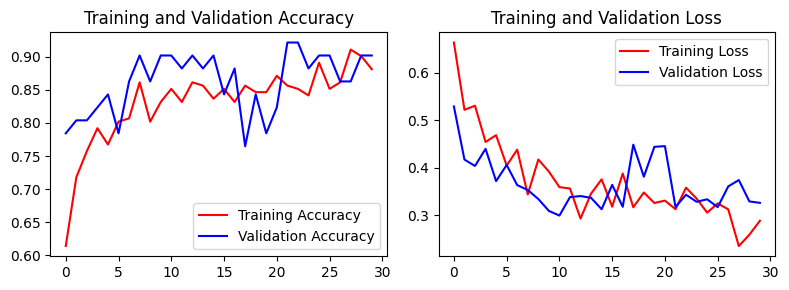

In [20]:
def plot_training(history):
    train_acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    train_loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(train_acc))

    plt.figure(figsize=(8, 3))

    plt.subplot(1,2,1)
    plt.plot(epochs, train_acc, 'r', label='Training Accuracy')
    plt.plot(epochs, val_acc, 'b', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend(loc=0)

    plt.subplot(1,2,2)
    plt.plot(epochs, train_loss, 'r', label='Training Loss')
    plt.plot(epochs, val_loss, 'b', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.legend(loc=0)

    plt.tight_layout()

plot_training(history)